In [167]:
import numpy as np
import pickle
import os
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [168]:
base_dir = r".\Dataset_100x5"
csv_path = os.path.join(base_dir, "labels.csv")
IMG_H, IMG_W, BATCH = 224, 224, 32
SEED = 42

In [169]:
# 2) Leggi CSV e crea path relativi
df = pd.read_csv(csv_path)

df['filepath'] = df['filepath'].str.replace('\\', '/', regex=False) # - normalizza i separatori verso '/', per sicurezza cross-platform
df['filepath'] = df['filepath'].str.replace(r'^Dataset_100x5\./', '', regex=True) # - rimuovi il prefisso "Dataset_100x5./"

In [170]:
df

,filepath,label
0,original/000000021147.jpg,Original
1,salt_pepper/000000021147.jpg,Salt & Pepper
2,gaussian/000000021147.jpg,Gaussian
3,uniform/000000021147.jpg,Uniform
4,erlang/000000021147.jpg,Erlang
...,...,...
495,original/000000581081.jpg,Original
496,salt_pepper/000000581081.jpg,Salt & Pepper
497,gaussian/000000581081.jpg,Gaussian
498,uniform/000000581081.jpg,Uniform


In [171]:
# Split stratificati (stessi esempi per classe)

# 70-15-15 training-validation-test split

# Splitto tutto in training e "temp"
train_df, temp_df = train_test_split(df, test_size=0.30, stratify=df['label'], random_state=SEED)

# Splitto temp in validation e test
val_df, test_df = train_test_split(temp_df, test_size=0.50, stratify=temp_df['label'], random_state=SEED)

print(f"Train: {len(train_df)/len(df)*100:.1f}%  |  Val: {len(val_df)/len(df)*100:.1f}%  |  Test: {len(test_df)/len(df)*100:.1f}%")

Train: 70.0%  |  Val: 15.0%  |  Test: 15.0%


In [172]:
# Preprocessing: rescaling, resizing, shuffling, one hot encoding

datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_dataframe(
    train_df, directory=base_dir,
    x_col="filepath", y_col="label", # colonne di df_train
    target_size=(IMG_H, IMG_W), # da settare bene
    batch_size=BATCH,
    class_mode="categorical", # voglio fare ohe
    shuffle=True,
    seed=SEED
)
val_gen = datagen.flow_from_dataframe(
    val_df, directory=base_dir,
    x_col="filepath", y_col="label",
    target_size=(IMG_H, IMG_W),
    batch_size=BATCH,
    class_mode="categorical",
    shuffle=False
)
test_gen = datagen.flow_from_dataframe(
    test_df, directory=base_dir,
    x_col="filepath", y_col="label",
    target_size=(IMG_H, IMG_W),
    batch_size=BATCH,
    class_mode="categorical",
    shuffle=False
)

train_gen.class_indices

Found 350 validated image filenames belonging to 5 classes.


Found 75 validated image filenames belonging to 5 classes.
Found 75 validated image filenames belonging to 5 classes.


{'Erlang': 0, 'Gaussian': 1, 'Original': 2, 'Salt & Pepper': 3, 'Uniform': 4}

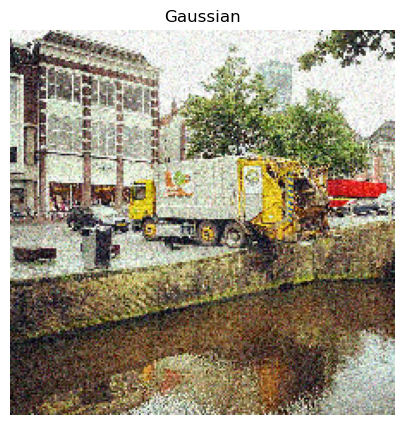

In [173]:
def plot_image(generator):
    """
    Estrae un'immagine random dal DirectoryIterator `generator`
    e la plotta con la sua label.
    """
    # 1) Scelgo un indice casuale tra 0 e generator.samples-1
    idx = random.randint(0, generator.samples - 1)
    
    # 2) Recupero il path assoluto dell'immagine
    img_path = generator.filepaths[idx]
    
    # 3) Carico e ridimensiono l'immagine secondo target_size del generatore
    img = load_img(img_path, target_size=generator.target_size)
    img_arr = img_to_array(img) / 255.0   # normalizzo [0,1]
    
    # 4) Trovo la label corrispondente
    class_idx = generator.classes[idx]
    inv_map = {v: k for k, v in generator.class_indices.items()}
    label = inv_map[class_idx]
    
    # 5) Plotto
    plt.figure(figsize=(5,5))
    plt.imshow(img_arr)
    plt.title(label)
    plt.axis('off')
    plt.show()

plot_image(train_gen)

In [174]:
model = models.Sequential()
model.add(layers.Input(shape=(IMG_H, IMG_W, 3)))
model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(train_gen.class_indices), activation='softmax'))

In [175]:
# Compilazione del modello
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [176]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,605 (42.61 MB)

 Trainable params: 11,169,605 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [164]:
# Carica i pesi dal file pickle
with open("/content/drive/MyDrive/Datasets/CatsDogs/vgg16.pkl", 'rb') as f:
    weights = pickle.load(f)

# Assegna i pesi al modello
model.set_weights(weights)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Datasets/CatsDogs/vgg16.pkl'

In [177]:
# Training
history = model.fit(train_gen, validation_data=val_gen, epochs=30)

c:\Users\tomma\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 340ms/step - accuracy: 0.2538 - loss: 1.7018 - val_accuracy: 0.2267 - val_loss: 1.6217
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 262ms/step - accuracy: 0.2482 - loss: 1.6061 - val_accuracy: 0.2000 - val_loss: 1.6020
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 264ms/step - accuracy: 0.2306 - loss: 1.5874 - val_accuracy: 0.2133 - val_loss: 1.5904
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 259ms/step - accuracy: 0.2543 - loss: 1.5428 - val_accuracy: 0.2533 - val_loss: 1.5699
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 261ms/step - accuracy: 0.3132 - loss: 1.5039 - val_accuracy: 0.2267 - val_loss: 1.5710
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 264ms/step - accuracy: 0.3384 - loss: 1.4588 - val_accuracy: 0.2533 - val_loss: 1.5400
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 266ms/step - accuracy: 0.3827 - loss: 1.4048 - val_accuracy: 0.2533 - val_loss: 1.5337
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 269ms/step - accuracy: 0.3716 - loss: 1.4248 - val_accuracy: 0.

In [ ]:
model = load_model("/content/drive/MyDrive/Datasets/CatsDogs/cnn.keras")

In [ ]:
test_loss, test_acc = model.evaluate(test_gen) # CAZZO (37% accuracy)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.3753 - loss: 1.2085


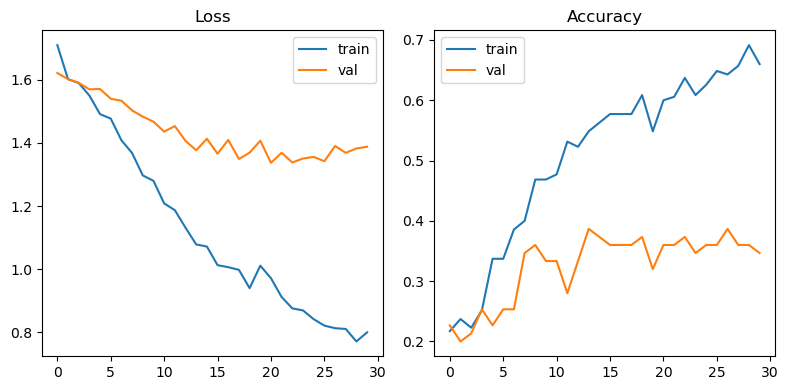

In [179]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [35]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalizzazione delle immagini (da 0-255 a 0-1)
x_train = x_train / 255.0
x_test = x_test / 255.0

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [42]:
model = tf.keras.models.Sequential()
model.add(Flatten(input_shape=(28,28)))    # flattens the 28x28 images into arrays of 784 pixels
model.add(Dense(128, activation='relu'))   # 1st hidden layer
model.add(Dense(128, activation='relu'))   # 2nd hidden layer
model.add(Dense(10, activation='softmax')) # output layer

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

c:\Users\tomma\anaconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [43]:
model.fit(x_train, y_train, epochs=4) #99.79%, 0.0070 loss

Epoch 1/4
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8823 - loss: 0.4054
Epoch 2/4
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9700 - loss: 0.0983
Epoch 3/4
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9783 - loss: 0.0677
Epoch 4/4
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9850 - loss: 0.0484


In [53]:
predictions = model.predict(x_test)
y_pred = [np.argmax(prediction) for prediction in predictions]

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step
